<a href="https://colab.research.google.com/github/MikeSalnikov/Data-analysis-algorithms/blob/main/HW6_web6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 6

Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.
Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев).
Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

Использую один из "игрушечных" датасетов из той же библиотеки (информация о пациентах с диабетом): 

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделяю выборку на обучающую и тестовую в соотношении 75/25: 

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишу функцию, реализующую предсказание в градиентном бустинге: 

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки буду использовать среднеквадратичную ошибку. Реализую соответствующую функцию: 

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Использую $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализую ее также в виде функции (коэффициент 2 можно отбросить): 

In [6]:
def residual(y, z):
    return - (z - y)

Реализую функцию обучения градиентного бустинга: 

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # деревья буду записывать в список
    trees = []
    
    # буду записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаю на выборке и добавляю в список
        if len(trees) == 0:
            # обучаю первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # получаю ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы, начиная со второго, обучаю на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучаю несколько моделей с разными параметрами и исследую их поведение (сначала шаг градиента): 

In [8]:
# Число деревьев в ансамбле
n_trees = 20

# Максимальная глубина деревьев
max_depth = 3

In [9]:
# Шаги
eta1 = 0.09

trees1, train_errors1, test_errors1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta1)

eta2 = 0.075

trees2, train_errors2, test_errors2 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta2)

eta3 = 0.065

trees3, train_errors3, test_errors3 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta3)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [11]:
evaluate_alg(X_train, X_test, y_train, y_test, trees1, eta1)

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.09 на тренировочной выборке: 2680.479373327966
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.09 на тестовой выборке: 4092.745495834357


In [12]:
evaluate_alg(X_train, X_test, y_train, y_test, trees2, eta2)

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.075 на тренировочной выборке: 3361.2391213146107
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.075 на тестовой выборке: 4612.174162007562


In [13]:
evaluate_alg(X_train, X_test, y_train, y_test, trees3, eta3)

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.065 на тренировочной выборке: 4085.997539205226
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.065 на тестовой выборке: 5163.496848675279


Построю график зависимости ошибки на обучающей и тестовой выборках от числа итераций при разных значениях шага градиента: 

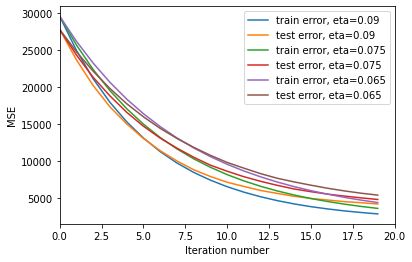

In [14]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), train_errors1, label=f'train error, eta={eta1}')
plt.plot(list(range(n_trees)), test_errors1, label=f'test error, eta={eta1}')
plt.plot(list(range(n_trees)), train_errors2, label=f'train error, eta={eta2}')
plt.plot(list(range(n_trees)), test_errors2, label=f'test error, eta={eta2}')
plt.plot(list(range(n_trees)), train_errors3, label=f'train error, eta={eta3}')
plt.plot(list(range(n_trees)), test_errors3, label=f'test error, eta={eta3}')
plt.legend(loc='upper right')
plt.show()

Из графика видно, что при разных значениях шага градиента (eta) скорость уменьшения ошибки (MSE) разная. 

Так, при eta=0.09 ошибка на тестовой выборке минимальна. Но в правой части можно заметить начало переобучения модели. 

Теперь обучаю несколько моделей с разными параметрами и исследую их поведение (теперь глубина деревьев): 

In [15]:
# Число деревьев в ансамбле
n_trees = 20

# Шаг
eta = 0.09

In [16]:
max_depth = 1

trees1, train_errors1, test_errors1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees1, eta)

Ошибка алгоритма из 20 деревьев глубиной 1     с шагом 0.09 на тренировочной выборке: 3773.9185534991834
Ошибка алгоритма из 20 деревьев глубиной 1     с шагом 0.09 на тестовой выборке: 4379.376147285174


In [17]:
max_depth = 2

trees2, train_errors2, test_errors2 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees2, eta)

Ошибка алгоритма из 20 деревьев глубиной 2     с шагом 0.09 на тренировочной выборке: 3198.9463277035775
Ошибка алгоритма из 20 деревьев глубиной 2     с шагом 0.09 на тестовой выборке: 4170.113249491465


In [18]:
max_depth = 5

trees3, train_errors3, test_errors3 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees3, eta)

Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.09 на тренировочной выборке: 1574.5398517866952
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.09 на тестовой выборке: 4438.772117761845


Построю график зависимости ошибки на обучающей и тестовой выборках от числа итераций при разных значениях глубины деревьев: 

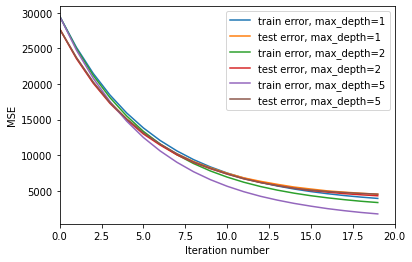

In [19]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), train_errors1, label=f'train error, max_depth=1')
plt.plot(list(range(n_trees)), test_errors1, label=f'test error, max_depth=1')
plt.plot(list(range(n_trees)), train_errors2, label=f'train error, max_depth=2')
plt.plot(list(range(n_trees)), test_errors2, label=f'test error, max_depth=2')
plt.plot(list(range(n_trees)), train_errors3, label=f'train error, max_depth=5')
plt.plot(list(range(n_trees)), test_errors3, label=f'test error, max_depth=5')
plt.legend(loc='upper right')
plt.show()

Из графика видно, что при разных значениях максимальной глубины деревьев (max_depth) скорость уменьшения ошибки (MSE) разная. 

Так, при max_depth=2 ошибка на тестовой выборке минимальна. Но в правой части можно заметить начало переобучения модели. 

В целом становится понятным, что варьируя параметры обучения градиентного бустинга, можно добиваться различного уровня точности и качества модели.

В данном случае оптимальными гиперпараметрами стали eta=0.09 и max_depth=2.